## Get some stock data
We are going to update the get_stock_data function we are going to add the rsi.

In [20]:
import yfinance as yf
import pandas as pd

def get_stock_data(symbol, start="2010-01-01", end="2024-01-01"):
    """Fetch stock data from Yahoo Finance."""
    data = yf.download(symbol, start=start, end=end)
    file_name = f"{symbol}_{start}_{end}.csv"
    data.to_csv(file_name)
    headers = ['Date','Close','High','Low','Open','Volume']

    # Load CSV while skipping the first 3 lines
    stock = pd.read_csv(file_name, skiprows=3, names=headers)
    stock["SMA_5"] = stock["Close"].rolling(window=5).mean()
    stock["SMA_20"] = stock["Close"].rolling(window=20).mean()
    stock["Return"] = stock["Close"] - stock["Open"]
    stock["Volatility"] = stock["Return"].rolling(window=5).std()
    delta = stock["Close"].diff(1)
    delta.fillna(0, inplace=True)  # Fix: Replace NaN with 0

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()

    rs = avg_gain / (avg_loss + 1e-9)  # Avoid division by zero
    stock["RSI"] = 100 - (100 / (1 + rs))
    stock = stock.iloc[20:] # calc of 20 day moving average will lead ot NaN values
    return stock

data = get_stock_data("AAPL")
FEATURES = ["Close", "SMA_5", "SMA_20", "Return", "Volatility", "RSI"]
data[FEATURES].head()
data = data[FEATURES]
data = data.astype(float)
dates = data.index
print(data.head())

[*********************100%***********************]  1 of 1 completed

       Close     SMA_5    SMA_20    Return  Volatility        RSI
20  5.894132  5.957449  6.204051 -0.001505    0.146020  40.705361
21  5.995547  5.905387  6.181255  0.122180    0.165843  41.111477
22  5.779474  5.861811  6.152786 -0.140837    0.161059  37.621067
23  5.882095  5.882275  6.130036  0.085164    0.104118  42.533193
24  5.841769  5.878603  6.103162 -0.047247    0.105104  33.221108


## Replay Buffer
This class stores past experiences (state, action, reward, next state, done) in a buffer 
and assigns priorities to them based on how important they are for learning.

In [21]:
import numpy as np
import torch
import torch.nn as nn

# 🔹 Implement Prioritized Experience Replay (PER)
class PrioritizedReplayBuffer:
    def __init__(self, max_size=100000, alpha=0.6):
        self.max_size = max_size
        self.alpha = alpha  # Prioritization factor
        self.states, self.actions, self.rewards, self.next_states, self.dones = [], [], [], [], []
        self.priorities = []  # Stores priority for each experience

    def add(self, state, action, reward, next_state, done, td_error=1.0):
        """Add experience with priority based on TD error."""
        if len(self.states) >= self.max_size:
            del self.states[0], self.actions[0], self.rewards[0], self.next_states[0], self.dones[0], self.priorities[0]

        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.priorities.append(abs(td_error) + 1e-5)  # Small value to prevent zero probability

    def sample(self, batch_size, beta=0.4):
        """Sample experiences with probability proportional to priority."""
        priorities = np.array(self.priorities) ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.states), batch_size, p=probs)

        # Compute importance-sampling weights
        total = len(self.states)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return (torch.tensor(np.array(self.states), dtype=torch.float32)[indices],
                torch.tensor(np.array(self.actions), dtype=torch.int64)[indices],
                torch.tensor(np.array(self.rewards), dtype=torch.float32)[indices].unsqueeze(1),
                torch.tensor(np.array(self.next_states), dtype=torch.float32)[indices],
                torch.tensor(np.array(self.dones), dtype=torch.float32)[indices].unsqueeze(1),
                torch.tensor(weights, dtype=torch.float32).unsqueeze(1), indices)

    def update_priorities(self, indices, td_errors):
        """Update priorities after training using TD errors."""
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = abs(td_error.item()) + 1e-5

##  Define the MR.Q Trading Agent

The MRQTradingAgent is a reinforcement learning (RL) trading agent that uses a softmax based policy network to decide whether to buy, sell, or hold stocks. Unlike traditional Q-learning (DQN), MR.Q optimizes decisions using probabilistic action selection rather than selecting the action with the highest Q-value.

In [22]:
import random
import torch.optim as optim
class MRQTradingAgent:
    def __init__(self, state_dim, action_dim=3, learning_rate=0.001, exploration_prob=0.2):
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.exploration_prob = exploration_prob  

    def select_action(self, state):
        """MR.Q uses softmax-based selection with forced exploration."""
        if random.random() < self.exploration_prob:
            return random.choice([0, 1, 2])  # Random action (Buy, Sell, Hold)

        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = self.policy_network(state_tensor)
            return torch.multinomial(action_probs, 1).item()  # Sample from softmax probabilities

    def train(self, buffer, batch_size=32):
        if len(buffer.states) < batch_size:
            return  

        states, actions, rewards, next_states, dones, _, _ = buffer.sample(batch_size)

        actions_one_hot = torch.nn.functional.one_hot(actions, num_classes=3).float()
        q_values = self.policy_network(states)
        q_values = (q_values * actions_one_hot).sum(dim=1, keepdim=True)
        next_q_values = self.policy_network(next_states).max(dim=1, keepdim=True)[0]
        target_q_values = rewards + 0.99 * next_q_values * (1 - dones)
        
        loss = self.loss_fn(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## Define the DQN Trading Agent

This code implements a Deep Q-Network (DQN) trading agent that uses reinforcement learning to decide whether to buy, sell, or hold stocks based on historical market data.

In [23]:
import torch.nn as nn
import torch.optim as optim
import random

class DQNTradingAgent:
    def __init__(self, state_dim, action_dim=3, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, tau=0.005):
        self.q_network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

        # ✅ Target network (copy of q_network)
        self.q_target_network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )
        self.q_target_network.load_state_dict(self.q_network.state_dict())  
        self.q_target_network.eval()  

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.epsilon_min = epsilon_min  
        self.epsilon_decay = epsilon_decay  
        self.tau = tau  

    def update_target_network(self):
        """Soft update: Slowly blends target network weights with main network."""
        for target_param, param in zip(self.q_target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def select_action(self, state):
        """DQN selects actions using epsilon-greedy policy."""
        if random.random() < self.epsilon:  
            return random.choice([0, 1, 2])  

        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_values = self.q_network(state_tensor)
            return torch.argmax(action_values).item()

    def train(self, buffer, batch_size=32):
        if len(buffer.states) < batch_size:
            return  

        states, actions, rewards, next_states, dones, weights, indices = buffer.sample(batch_size)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_q_values = self.q_target_network(next_states).max(dim=1, keepdim=True)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        td_errors = target_q_values - q_values
        loss = (weights * td_errors.pow(2)).mean()  

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        buffer.update_priorities(indices, td_errors.abs())  

        self.update_target_network()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  
        return loss.item()


## Train Both Agents

In [24]:
# 🔹 Train Both Agents with Prioritized Experience Replay (PER)
buffer = PrioritizedReplayBuffer()
mrq_agent = MRQTradingAgent(state_dim=6)
dqn_agent = DQNTradingAgent(state_dim=6)

mrq_values, dqn_values = [10000], [10000]  # Initial capital values

def calculate_reward(action, next_price, current_price):
    """Computes reward based on action and price movement."""
    if action == 1 and next_price > current_price:  # Buy & price increases ✅
        return 5
    elif action == 2 and next_price < current_price:  # Sell & price drops ✅
        return 5
    elif action == 1 and next_price < current_price:  # Buy & price drops ❌
        return -5
    elif action == 2 and next_price > current_price:  # Sell & price increases ❌
        return -5
    return -1  # Encourage trading

for i in range(len(data) - 1):
    state = data.iloc[i].values
    next_state = data.iloc[i + 1].values
    next_price, current_price = next_state[0], state[0]

    # 🔹 Select actions
    mrq_action = mrq_agent.select_action(state)
    dqn_action = dqn_agent.select_action(state)

    # ✅ Compute rewards
    mrq_reward = calculate_reward(mrq_action, next_price, current_price)
    dqn_reward = calculate_reward(dqn_action, next_price, current_price)

    done = (i == len(data) - 2)  # Mark last step

    # 🔹 Store experiences in buffer
    buffer.add(state, mrq_action, mrq_reward, next_state, done)
    buffer.add(state, dqn_action, dqn_reward, next_state, done)

    # 🔹 Train the agents multiple times per step
    if len(buffer.states) > 32:
        for _ in range(10):
            mrq_agent.train(buffer)
            dqn_agent.train(buffer)

    # 🔹 Update portfolio values
    mrq_values.append(mrq_values[-1] + mrq_reward)
    dqn_values.append(dqn_values[-1] + dqn_reward)

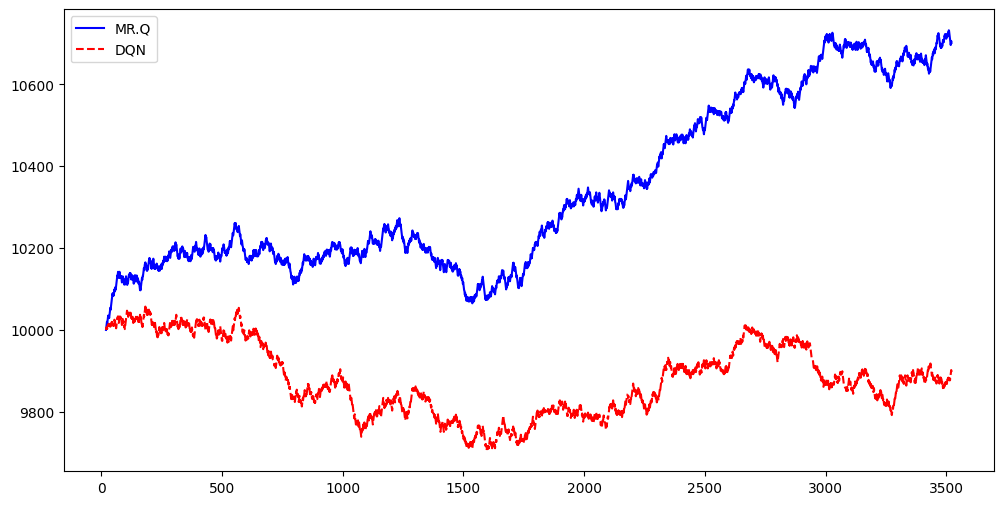

In [27]:
import matplotlib.pyplot as plt
# 🔹 Plot Performance Comparison
plt.figure(figsize=(12, 6))
plt.plot(dates, mrq_values, label="MR.Q", color="blue")
plt.plot(dates, dqn_values, label="DQN", color="red", linestyle="dashed")
plt.legend()
plt.show()


In [28]:
from collections import Counter

mrq_action_counts = Counter()
dqn_action_counts = Counter()

for i in range(len(data)-1):
    state = data.iloc[i].values
    mrq_action = mrq_agent.select_action(state)
    dqn_action = dqn_agent.select_action(state)

    mrq_action_counts[mrq_action] += 1
    dqn_action_counts[dqn_action] += 1

print("MR.Q Action Distribution:", mrq_action_counts)
print("DQN Action Distribution:", dqn_action_counts)


MR.Q Action Distribution: Counter({1: 3033, 2: 243, 0: 225})
DQN Action Distribution: Counter({1: 3424, 2: 64, 0: 13})
